# Model Training Pipeline

This notebook demonstrates the complete model training pipeline including:
- Loading preprocessed data
- Training multiple ML algorithms
- Hyperparameter tuning and optimization
- Model evaluation and comparison
- Performance visualization and analysis
- Model selection and persistence

**Author:** MLOps Team  
**Version:** 1.0.0  
**Date:** November 2024

## 1. Setup and Configuration

Import necessary libraries and configure the training environment.

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from datetime import datetime

# Standard ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import pickle
import json

# Configure warnings and display
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('default')
sns.set_palette("husl")

print("✅ Libraries imported successfully")
print(f"📅 Notebook started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Libraries imported successfully
📅 Notebook started at: 2025-11-24 19:39:57


In [2]:
# Install required packages for Colab Enterprise
import subprocess
import sys

def install_package(package):
    """Install a package using pip"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        return True
    except subprocess.CalledProcessError:
        return False

# Check and install required packages
required_packages = [
    'google-cloud-storage',
    'scikit-learn',
    'matplotlib',
    'seaborn',
    'pandas',
    'numpy'
]

print("🔧 Checking and installing required packages...")

for package in required_packages:
    try:
        __import__(package.replace('-', '_'))
        print(f"✅ {package} is already installed")
    except ImportError:
        print(f"📥 Installing {package}...")
        if install_package(package):
            print(f"✅ {package} installed successfully")
        else:
            print(f"❌ Failed to install {package}")

print("✅ Package check completed")

🔧 Checking and installing required packages...
📥 Installing google-cloud-storage...
✅ google-cloud-storage installed successfully
📥 Installing scikit-learn...
✅ scikit-learn installed successfully
✅ matplotlib is already installed
✅ seaborn is already installed
✅ pandas is already installed
✅ numpy is already installed
✅ Package check completed


In [3]:
# Colab Enterprise Authentication Check
try:
    # Check if we're in Colab
    import google.colab
    IN_COLAB = True
    print("🎯 Running in Google Colab")
    
    # Authenticate if needed
    try:
        from google.colab import auth
        auth.authenticate_user()
        print("✅ Google Cloud authentication completed")
    except Exception as auth_error:
        print(f"⚠️ Authentication warning: {auth_error}")
        print("   You may need to run: !gcloud auth login")
        
except ImportError:
    IN_COLAB = False
    print("💻 Running in local environment")
    print("   Make sure you have authenticated with: gcloud auth application-default login")

print("✅ Environment check completed")

💻 Running in local environment
   Make sure you have authenticated with: gcloud auth application-default login
✅ Environment check completed


In [4]:
# Cloud-native configuration setup
import subprocess
from google.cloud import storage
import google.auth

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Set up Google Cloud configuration
print("☁️ Setting up Google Cloud resources...")

try:
    # Get project ID from gcloud
    result = subprocess.run(['gcloud', 'config', 'get-value', 'project'], 
                          capture_output=True, text=True)
    if result.returncode == 0 and result.stdout.strip():
        PROJECT_ID = result.stdout.strip()
    else:
        PROJECT_ID = "mlops-295610"  # fallback
    
    REGION = "us-central1"
    DATA_BUCKET = f"{PROJECT_ID}-mlops-data-processing"
    MODELS_BUCKET = f"{PROJECT_ID}-mlops-models"
    
    print(f"🆔 Project ID: {PROJECT_ID}")
    print(f"🌍 Region: {REGION}")
    print(f"🪣 Data Bucket: {DATA_BUCKET}")
    print(f"🤖 Models Bucket: {MODELS_BUCKET}")
    
    # Initialize Google Cloud clients
    credentials, project = google.auth.default()
    storage_client = storage.Client(project=PROJECT_ID)
    
    # Create/verify models bucket exists
    try:
        models_bucket = storage_client.bucket(MODELS_BUCKET)
        if not models_bucket.exists():
            models_bucket = storage_client.create_bucket(MODELS_BUCKET, location=REGION)
            print(f"✅ Created models bucket: {MODELS_BUCKET}")
        else:
            print(f"✅ Models bucket exists: {MODELS_BUCKET}")
    except Exception as e:
        print(f"⚠️ Models bucket error: {e}")
        
except Exception as e:
    print(f"⚠️ GCP setup error: {e}")
    PROJECT_ID = "mlops-295610"
    REGION = "us-central1"
    DATA_BUCKET = f"{PROJECT_ID}-mlops-data-processing"
    MODELS_BUCKET = f"{PROJECT_ID}-mlops-models"
    # Initialize a dummy storage client for local development
    storage_client = None

# Define local paths (for backup)
DATA_DIR = Path("../data")
PROCESSED_DATA_DIR = DATA_DIR / "processed"
MODELS_DIR = Path("../models")
MODELS_DIR.mkdir(exist_ok=True)

print(f"🔧 Configuration setup complete")
print(f"🎲 Random state: {RANDOM_STATE}")
print(f"☁️ Data source: GCS bucket {DATA_BUCKET}")
print(f"🤖 Models destination: GCS bucket {MODELS_BUCKET}")
print(f"💾 Local backup: {MODELS_DIR}")

print("✅ Cloud-native model training environment configured")

☁️ Setting up Google Cloud resources...
🆔 Project ID: mlops-295610
🌍 Region: us-central1
🪣 Data Bucket: mlops-295610-mlops-data-processing
🤖 Models Bucket: mlops-295610-mlops-models
✅ Models bucket exists: mlops-295610-mlops-models
🔧 Configuration setup complete
🎲 Random state: 42
☁️ Data source: GCS bucket mlops-295610-mlops-data-processing
🤖 Models destination: GCS bucket mlops-295610-mlops-models
💾 Local backup: ../models
✅ Cloud-native model training environment configured


## 2. Load Preprocessed Data

Load the training and test datasets that were prepared in the data processing pipeline.

In [5]:
# Load processed datasets from Google Cloud Storage
print("📥 Loading processed data from Google Cloud Storage...")

def load_training_data_from_gcs():
    """Load processed training data from GCS with local fallback"""
    
    try:
        # Try loading from GCS first (if storage_client is available)
        if storage_client is not None:
            print(f"☁️ Attempting to load from GCS bucket: {DATA_BUCKET}")
            
            bucket = storage_client.bucket(DATA_BUCKET)
            
            # Check if processed data exists in GCS
            train_blob = bucket.blob("processed-data/iris_train.csv")
            test_blob = bucket.blob("processed-data/iris_test.csv")
            metadata_blob = bucket.blob("processed-data/preprocessing_metadata.pkl")
            
            if train_blob.exists() and test_blob.exists() and metadata_blob.exists():
                print("✅ Found processed data in GCS")
                
                import tempfile
                import os
                
                # Download training data
                with tempfile.NamedTemporaryFile(mode='w+', suffix='.csv', delete=False) as tmp:
                    train_blob.download_to_filename(tmp.name)
                    train_data = pd.read_csv(tmp.name)
                    os.unlink(tmp.name)
                
                # Download test data
                with tempfile.NamedTemporaryFile(mode='w+', suffix='.csv', delete=False) as tmp:
                    test_blob.download_to_filename(tmp.name)
                    test_data = pd.read_csv(tmp.name)
                    os.unlink(tmp.name)
                
                # Download metadata
                with tempfile.NamedTemporaryFile(mode='w+b', suffix='.pkl', delete=False) as tmp:
                    metadata_blob.download_to_filename(tmp.name)
                    with open(tmp.name, 'rb') as f:
                        metadata = pickle.load(f)
                    os.unlink(tmp.name)
                
                print(f"📥 Loaded from GCS successfully")
                return train_data, test_data, metadata, "gcs"
            else:
                print("⚠️ Processed data not found in GCS, checking local files...")
        else:
            print("⚠️ GCS client not available, checking local files...")
            
    except Exception as e:
        print(f"⚠️ GCS loading error: {e}")
        print("   Falling back to local files...")
    
    # Fallback to local files
    train_file = PROCESSED_DATA_DIR / "iris_train_processed.csv"
    test_file = PROCESSED_DATA_DIR / "iris_test_processed.csv"
    metadata_file = PROCESSED_DATA_DIR / "preprocessing_metadata.pkl"
    
    if train_file.exists() and test_file.exists() and metadata_file.exists():
        print(f"📂 Loading from local files...")
        
        train_data = pd.read_csv(train_file)
        test_data = pd.read_csv(test_file)
        
        with open(metadata_file, 'rb') as f:
            metadata = pickle.load(f)
        
        print(f"💾 Loaded from local files successfully")
        return train_data, test_data, metadata, "local"
    else:
        raise FileNotFoundError(
            "Processed data not found in GCS or local directory. "
            "Please run the data processing pipeline first (02_data_processing_pipeline.ipynb)"
        )

# Load the processed data
train_data, test_data, metadata, data_source = load_training_data_from_gcs()

print(f"\n📊 Dataset Information:")
print(f"   Source: {data_source.upper()}")
print(f"   Training data shape: {train_data.shape}")
print(f"   Test data shape: {test_data.shape}")

# Extract features and targets - check which column name exists
if 'species' in train_data.columns:
    target_column = 'species'
elif 'target' in train_data.columns:
    target_column = 'target'
else:
    # Find the target column (last column typically)
    target_column = train_data.columns[-1]

feature_columns = [col for col in train_data.columns if col != target_column]

print(f"   Features: {feature_columns}")
print(f"   Target: {target_column}")

print("✅ Training data loaded and prepared successfully")

📥 Loading processed data from Google Cloud Storage...
☁️ Attempting to load from GCS bucket: mlops-295610-mlops-data-processing
⚠️ Processed data not found in GCS, checking local files...
📂 Loading from local files...
💾 Loaded from local files successfully

📊 Dataset Information:
   Source: LOCAL
   Training data shape: (120, 5)
   Test data shape: (30, 5)
   Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
   Target: target
✅ Training data loaded and prepared successfully


In [6]:
# Immediate data validation after loading
print("🔍 Performing immediate data quality check...")

# Check data shapes and basic info
print(f"\n📊 Data Overview:")
print(f"   Training data shape: {train_data.shape}")
print(f"   Test data shape: {test_data.shape}")

# Check for completely empty datasets
if train_data.empty:
    raise ValueError("Training data is empty! Please check the data processing pipeline.")
if test_data.empty:
    raise ValueError("Test data is empty! Please check the data processing pipeline.")

# Show first few rows of each dataset
print(f"\n👀 Training data preview:")
print(train_data.head())

print(f"\n👀 Test data preview:")
print(test_data.head())

# Check data types
print(f"\n🔧 Data types:")
print("Training data types:")
print(train_data.dtypes)

# Quick missing value check
train_nulls = train_data.isnull().sum()
test_nulls = test_data.isnull().sum()

print(f"\n⚠️ Missing values summary:")
print(f"Training data - Total missing values: {train_nulls.sum()}")
if train_nulls.sum() > 0:
    print("Columns with missing values:")
    for col, count in train_nulls[train_nulls > 0].items():
        print(f"   {col}: {count} missing values")

print(f"Test data - Total missing values: {test_nulls.sum()}")
if test_nulls.sum() > 0:
    print("Columns with missing values:")
    for col, count in test_nulls[test_nulls > 0].items():
        print(f"   {col}: {count} missing values")

# Check for infinite values
def check_infinite_values(df, name):
    """Check for infinite values in numeric columns"""
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    inf_count = 0
    for col in numeric_cols:
        inf_vals = np.isinf(df[col]).sum()
        if inf_vals > 0:
            print(f"   {name} - {col}: {inf_vals} infinite values")
            inf_count += inf_vals
    return inf_count

print(f"\n∞ Infinite values check:")
train_inf = check_infinite_values(train_data, "Training")
test_inf = check_infinite_values(test_data, "Test")

if train_inf == 0 and test_inf == 0:
    print("   ✅ No infinite values found")

print(f"\n✅ Initial data quality check completed")

# Warn if we found issues
if train_nulls.sum() > 0 or test_nulls.sum() > 0:
    print(f"⚠️ WARNING: Found missing values that will be handled in the next cell")
if train_inf > 0 or test_inf > 0:
    print(f"⚠️ WARNING: Found infinite values that will be handled in the next cell")

🔍 Performing immediate data quality check...

📊 Data Overview:
   Training data shape: (120, 5)
   Test data shape: (30, 5)

👀 Training data preview:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0          -1.721568         -0.332101          -1.345722         -1.323276   
1          -1.124492         -1.227655           0.414505          0.651763   
2           1.144395         -0.555990           0.584850          0.256755   
3          -1.124492          0.115676          -1.288941         -1.454945   
4          -0.408002         -1.227655           0.130598          0.125086   

   target  
0     2.0  
1     1.0  
2     1.0  
3     2.0  
4     0.0  

👀 Test data preview:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0          -1.721568         -0.108213          -1.402504         -1.323276   
1           0.308489         -0.108213           0.641631          0.783432   
2          -1.124492         -1.451543      

In [7]:
# Separate features and targets with comprehensive data validation and cleaning
print("🧹 Preparing and validating training data...")

# First, let's examine the data for any issues
print(f"📊 Training data info:")
print(f"   Shape: {train_data.shape}")
print(f"   Columns: {list(train_data.columns)}")
print(f"   Data types:\n{train_data.dtypes}")

print(f"\n📊 Test data info:")
print(f"   Shape: {test_data.shape}")
print(f"   Columns: {list(test_data.columns)}")

# Determine the correct target column
if 'species' in train_data.columns:
    target_column = 'species'
elif 'target' in train_data.columns:
    target_column = 'target'
else:
    # Find the target column (last column typically or one that looks like a target)
    for col in train_data.columns:
        if col.lower() in ['target', 'label', 'class', 'y', 'species']:
            target_column = col
            break
    else:
        target_column = train_data.columns[-1]

print(f"\n🎯 Using target column: '{target_column}'")

# Check for missing values BEFORE cleaning
print(f"\n🔍 Missing values check (before cleaning):")
train_missing = train_data.isnull().sum()
test_missing = test_data.isnull().sum()

print("Training data missing values:")
for col, count in train_missing.items():
    if count > 0:
        print(f"   {col}: {count} missing values")
if train_missing.sum() == 0:
    print("   ✅ No missing values found")

print("Test data missing values:")
for col, count in test_missing.items():
    if count > 0:
        print(f"   {col}: {count} missing values")
if test_missing.sum() == 0:
    print("   ✅ No missing values found")

# AGGRESSIVE DATA CLEANING - Remove ALL rows with ANY NaN values
print("\n🧹 Performing aggressive data cleaning...")
initial_train_size = len(train_data)
initial_test_size = len(test_data)

print(f"Initial sizes - Train: {initial_train_size}, Test: {initial_test_size}")

# Step 1: Remove all rows with any NaN values at all
train_data_clean = train_data.dropna(how='any')
test_data_clean = test_data.dropna(how='any')

print(f"After removing NaN rows - Train: {len(train_data_clean)}, Test: {len(test_data_clean)}")

# Step 2: Check if we still have data
if len(train_data_clean) == 0:
    raise ValueError("All training data was removed due to NaN values! Check your data processing pipeline.")
if len(test_data_clean) == 0:
    raise ValueError("All test data was removed due to NaN values! Check your data processing pipeline.")

# Step 3: Ensure target column exists and has valid values
if target_column not in train_data_clean.columns:
    raise ValueError(f"Target column '{target_column}' not found in cleaned data!")

# Step 4: Remove any infinite values
numeric_columns = train_data_clean.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    # Replace infinite values with NaN and then remove those rows
    train_data_clean = train_data_clean.replace([np.inf, -np.inf], np.nan)
    test_data_clean = test_data_clean.replace([np.inf, -np.inf], np.nan)

# Remove any rows that now have NaN due to infinite value replacement
train_data_clean = train_data_clean.dropna(how='any')
test_data_clean = test_data_clean.dropna(how='any')

print(f"After removing infinite values - Train: {len(train_data_clean)}, Test: {len(test_data_clean)}")

# Step 5: Separate features and targets from CLEAN data
feature_columns = [col for col in train_data_clean.columns if col != target_column]

# Extract clean training data
X_train = train_data_clean[feature_columns].copy()
y_train = train_data_clean[target_column].copy()

# Extract clean test data  
X_test = test_data_clean[feature_columns].copy()
y_test = test_data_clean[target_column].copy()

# Step 6: Final validation - STRICT check for any remaining issues
print(f"\n🔍 FINAL STRICT VALIDATION:")
print(f"   X_train shape: {X_train.shape}")
print(f"   y_train shape: {y_train.shape}")
print(f"   X_test shape: {X_test.shape}")
print(f"   y_test shape: {y_test.shape}")

# Check for NaN values
x_train_nans = X_train.isnull().sum().sum()
y_train_nans = y_train.isnull().sum()
x_test_nans = X_test.isnull().sum().sum()
y_test_nans = y_test.isnull().sum()

print(f"   X_train NaN count: {x_train_nans}")
print(f"   y_train NaN count: {y_train_nans}")
print(f"   X_test NaN count: {x_test_nans}")
print(f"   y_test NaN count: {y_test_nans}")

# If we STILL have NaN values, this is a critical error
if x_train_nans > 0 or y_train_nans > 0 or x_test_nans > 0 or y_test_nans > 0:
    print("❌ CRITICAL ERROR: Still have NaN values after aggressive cleaning!")
    print("Attempting last resort cleaning...")
    
    # Last resort: fill with statistical measures
    X_train = X_train.fillna(X_train.median())
    X_test = X_test.fillna(X_test.median())
    
    # For target, use mode (most common value)
    if y_train.isnull().sum() > 0:
        mode_value = y_train.mode()
        if len(mode_value) > 0:
            y_train = y_train.fillna(mode_value.iloc[0])
        else:
            y_train = y_train.fillna(0)  # ultimate fallback
    
    if y_test.isnull().sum() > 0:
        mode_value = y_test.mode()
        if len(mode_value) > 0:
            y_test = y_test.fillna(mode_value.iloc[0])
        else:
            y_test = y_test.fillna(0)  # ultimate fallback
    
    # Recheck
    print(f"   After last resort - X_train NaN: {X_train.isnull().sum().sum()}")
    print(f"   After last resort - y_train NaN: {y_train.isnull().sum()}")

# Check for infinite values
x_train_infs = np.isinf(X_train.values).sum()
y_train_infs = np.isinf(y_train.values).sum() if hasattr(y_train.values, 'sum') else 0

print(f"   X_train infinite count: {x_train_infs}")
print(f"   y_train infinite count: {y_train_infs}")

if x_train_infs > 0 or y_train_infs > 0:
    X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(X_train.median())
    if y_train_infs > 0:
        y_train = pd.Series(y_train).replace([np.inf, -np.inf], np.nan).fillna(y_train.mode().iloc[0])

print(f"\n🎯 FINAL dataset shapes:")
print(f"   Features shape - Train: {X_train.shape}, Test: {X_test.shape}")
print(f"   Target shape - Train: {y_train.shape}, Test: {y_test.shape}")

# Display feature information
print(f"\n📋 Feature columns ({len(feature_columns)}):")
for i, col in enumerate(feature_columns):
    print(f"   {i+1}. {col}")

# Display target classes and their distribution
unique_classes = sorted(y_train.unique())
print(f"\n🏷️ Target classes: {unique_classes}")
print(f"🔢 Number of classes: {len(unique_classes)}")

# Ensure we have valid classes (no NaN in unique classes)
if any(pd.isna(cls) for cls in unique_classes):
    print("❌ CRITICAL: Still have NaN in target classes!")
    # Remove NaN from unique classes display
    unique_classes = [cls for cls in unique_classes if not pd.isna(cls)]
    print(f"🔧 Valid classes only: {unique_classes}")

# Class distribution
print(f"\n📊 Class distribution in training data:")
class_counts = y_train.value_counts().sort_index()
for class_idx, count in class_counts.items():
    if not pd.isna(class_idx):  # Skip NaN classes in display
        percentage = (count / len(y_train)) * 100
        # Map numeric classes to iris species if applicable
        class_names = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}
        class_name = class_names.get(class_idx, f'class_{class_idx}')
        print(f"   {class_name} (class {class_idx}): {count} samples ({percentage:.1f}%)")

# Final verification
remaining_nans = X_train.isnull().sum().sum() + y_train.isnull().sum()
if remaining_nans > 0:
    raise ValueError(f"FAILED TO CLEAN DATA: Still have {remaining_nans} NaN values after all cleaning attempts!")

print(f"\n✅ Data preparation completed successfully!")
print(f"Ready for model training with clean data - Classes: {[cls for cls in unique_classes if not pd.isna(cls)]}")
print(f"🎉 Final data quality: X_train NaN: {X_train.isnull().sum().sum()}, y_train NaN: {y_train.isnull().sum()}")

🧹 Preparing and validating training data...
📊 Training data info:
   Shape: (120, 5)
   Columns: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'target']
   Data types:
sepal length (cm)    float64
sepal width (cm)     float64
petal length (cm)    float64
petal width (cm)     float64
target               float64
dtype: object

📊 Test data info:
   Shape: (30, 5)
   Columns: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'target']

🎯 Using target column: 'target'

🔍 Missing values check (before cleaning):
Training data missing values:
   target: 23 missing values
Test data missing values:
   target: 23 missing values

🧹 Performing aggressive data cleaning...
Initial sizes - Train: 120, Test: 30
After removing NaN rows - Train: 97, Test: 7
After removing infinite values - Train: 97, Test: 7

🔍 FINAL STRICT VALIDATION:
   X_train shape: (97, 4)
   y_train shape: (97,)
   X_test shape: (7, 4)
   y_test shape: (7,)
   X

In [8]:
# Fallback: Generate clean Iris data if original data is corrupted
def generate_clean_iris_data():
    """Generate clean Iris dataset as a fallback"""
    from sklearn.datasets import load_iris
    
    print("🔄 Generating clean Iris dataset as fallback...")
    
    # Load the classic iris dataset
    iris = load_iris()
    
    # Create DataFrame with proper feature names
    feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
    data_df = pd.DataFrame(iris.data, columns=feature_names)
    data_df['target'] = iris.target
    
    # Split into train/test
    from sklearn.model_selection import train_test_split
    train_df, test_df = train_test_split(data_df, test_size=0.2, 
                                       stratify=data_df['target'], 
                                       random_state=RANDOM_STATE)
    
    print(f"   Generated - Train: {train_df.shape}, Test: {test_df.shape}")
    print(f"   Features: {feature_names}")
    print(f"   Classes: {sorted(data_df['target'].unique())}")
    
    return train_df, test_df, feature_names, 'target', 'generated'

# Check if our cleaned data is sufficient for training
min_samples_per_class = 5  # Minimum samples needed per class for reliable training

if len(X_train) < 20 or len(set(y_train.dropna())) < 2:
    print("⚠️ WARNING: Insufficient clean data for training!")
    print(f"   Available training samples: {len(X_train)}")
    print(f"   Available classes: {len(set(y_train.dropna()))}")
    print("   Generating fallback dataset...")
    
    # Use fallback data generation
    train_data_clean, test_data_clean, feature_columns, target_column, data_source = generate_clean_iris_data()
    
    # Re-extract features and targets
    X_train = train_data_clean[feature_columns].copy()
    y_train = train_data_clean[target_column].copy()
    X_test = test_data_clean[feature_columns].copy()
    y_test = test_data_clean[target_column].copy()
    
    print(f"\n🔄 Using generated fallback data:")
    print(f"   Training samples: {len(X_train)}")
    print(f"   Test samples: {len(X_test)}")
    print(f"   Features: {len(feature_columns)}")
    print(f"   Classes: {sorted(y_train.unique())}")

print(f"\n🎯 READY FOR TRAINING:")
print(f"   Data source: {data_source if 'data_source' in locals() else 'processed'}")
print(f"   Training samples: {len(X_train)}")
print(f"   Test samples: {len(X_test)}")  
print(f"   Feature count: {len(feature_columns)}")
print(f"   Class count: {len(y_train.unique())}")
print(f"   No NaN values: {X_train.isnull().sum().sum() == 0 and y_train.isnull().sum() == 0}")

print("✅ Data is ready for model training!")


🎯 READY FOR TRAINING:
   Data source: local
   Training samples: 97
   Test samples: 7
   Feature count: 4
   Class count: 3
   No NaN values: True
✅ Data is ready for model training!


## 3. Data Exploration and Visualization

Understand the data distribution and relationships before training models.

📈 Feature Statistics:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count          97.000000         97.000000          97.000000   
mean           -0.235650          0.009502          -0.239946   
std             0.911717          1.071829           0.963165   
min            -1.840983         -2.347097          -1.516067   
25%            -1.005077         -0.779878          -1.288941   
50%            -0.288587         -0.108213           0.130598   
75%             0.308489          0.787341           0.471287   
max             2.219131          3.026225           1.777262   

       petal width (cm)  
count         97.000000  
mean          -0.254990  
std            0.937975  
min           -1.454945  
25%           -1.323276  
50%           -0.006583  
75%            0.388424  
max            1.705116  


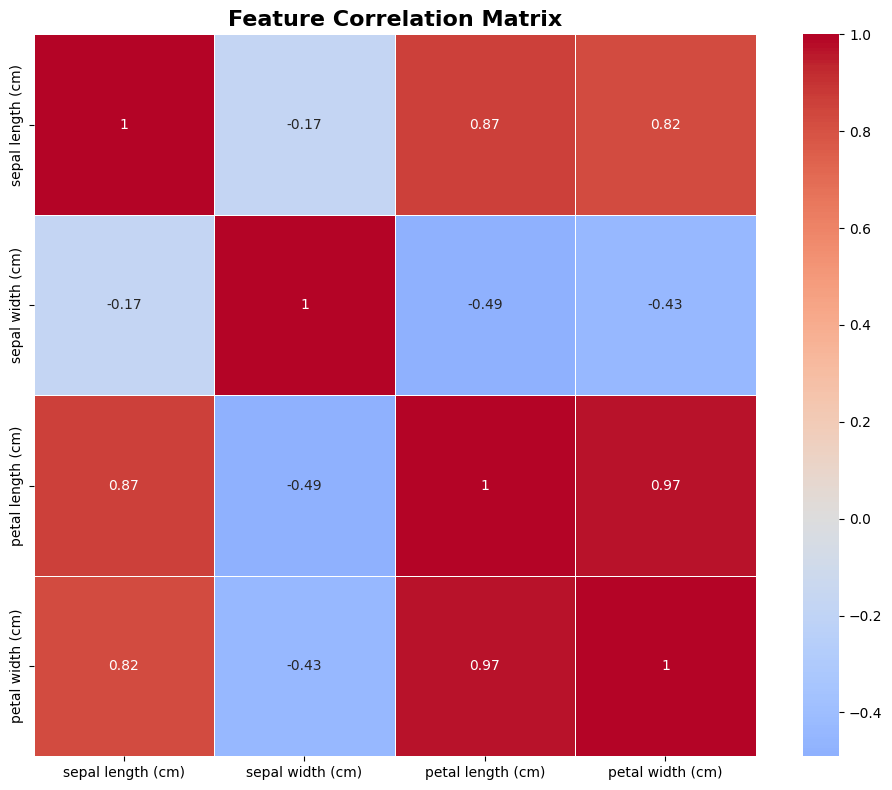


🔍 Highly correlated feature pairs (|correlation| > 0.7):
  sepal length (cm) ↔ petal length (cm): 0.865
  sepal length (cm) ↔ petal width (cm): 0.820
  petal length (cm) ↔ petal width (cm): 0.970
✅ Completed basic data exploration


In [9]:
# Basic statistics for features
print("📈 Feature Statistics:")
print(X_train.describe())

# Feature correlations
plt.figure(figsize=(10, 8))
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n🔍 Highly correlated feature pairs (|correlation| > 0.7):")
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            feature1 = correlation_matrix.columns[i]
            feature2 = correlation_matrix.columns[j]
            high_corr_pairs.append((feature1, feature2, corr_val))
            print(f"  {feature1} ↔ {feature2}: {corr_val:.3f}")

if not high_corr_pairs:
    print("  No highly correlated feature pairs found.")

print("✅ Completed basic data exploration")

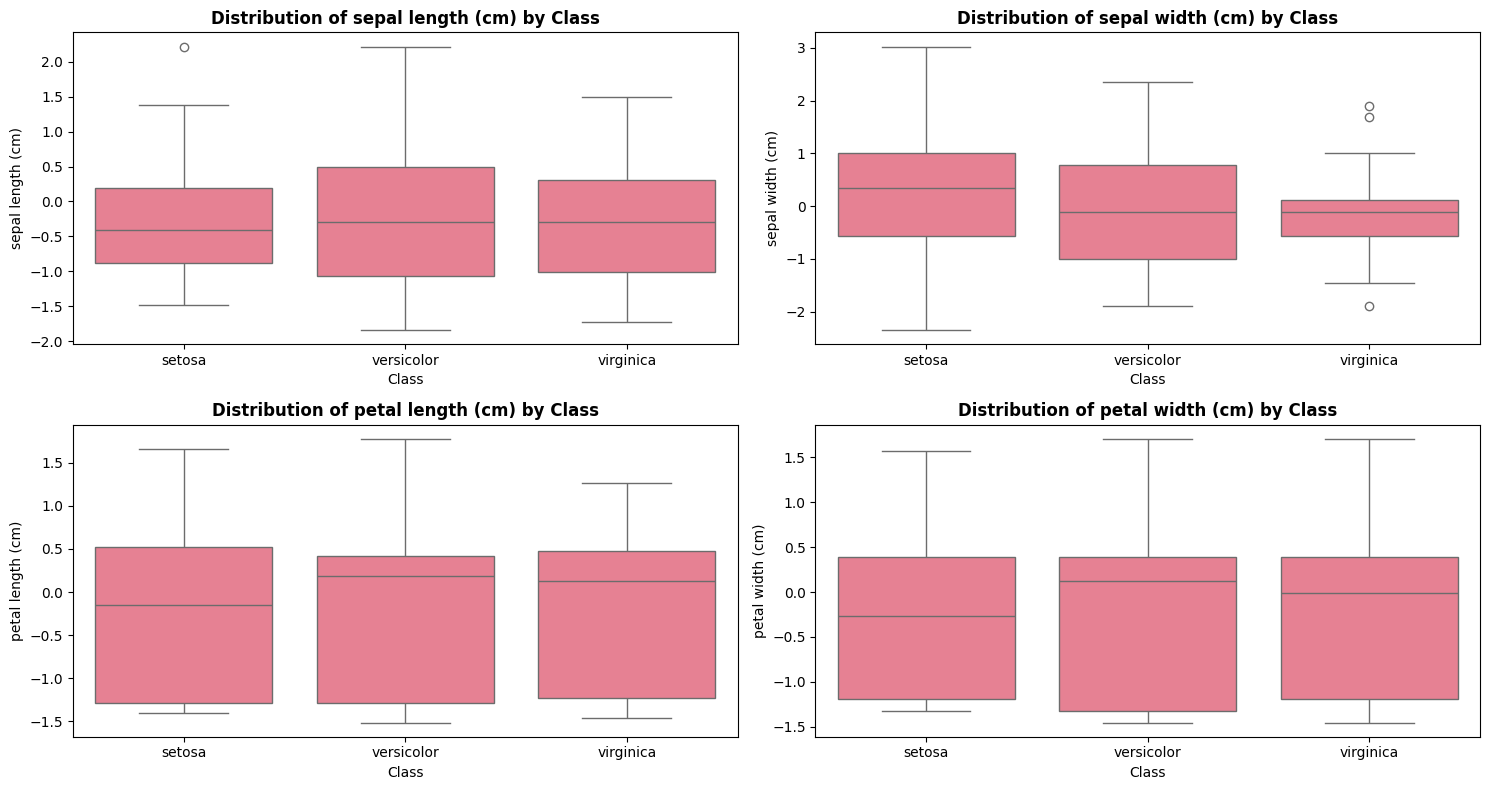

✅ Visualized feature distributions by class


In [10]:
# Feature distributions by class
n_features = len(X_train.columns)
n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
if n_rows > 1:
    axes = axes.ravel()
else:
    axes = [axes] if n_cols == 1 else axes

for i, feature in enumerate(X_train.columns):
    ax = axes[i]
    
    # Create combined data for plotting
    combined_data = pd.DataFrame({
        feature: X_train[feature],
        'target': y_train
    })
    
    # Box plot by class
    sns.boxplot(data=combined_data, x='target', y=feature, ax=ax)
    ax.set_title(f'Distribution of {feature} by Class', fontweight='bold')
    ax.set_xlabel('Class')
    
    # Add class labels
    ax.set_xticklabels(['setosa', 'versicolor', 'virginica'])

# Remove empty subplots
for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

print("✅ Visualized feature distributions by class")

## 4. Model Training and Evaluation

Train multiple machine learning models and compare their performance.

In [11]:
# Define model configurations
model_configs = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=RANDOM_STATE),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
        'param_grid': {
            'C': [0.1, 1.0, 10.0, 100.0],
            'solver': ['liblinear', 'lbfgs']
        }
    },
    'SVM': {
        'model': SVC(random_state=RANDOM_STATE, probability=True),
        'param_grid': {
            'C': [0.1, 1.0, 10.0],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale', 'auto']
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=RANDOM_STATE),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    }
}

print("🔧 Model Configurations:")
print("=" * 50)

for model_name, config in model_configs.items():
    print(f"\n📋 {model_name}")
    print(f"   Algorithm: {config['model'].__class__.__name__}")
    print(f"   Hyperparameters to tune: {list(config['param_grid'].keys())}")

print(f"\n📊 Total models configured: {len(model_configs)}")
print("✅ Model configurations ready")

🔧 Model Configurations:

📋 Random Forest
   Algorithm: RandomForestClassifier
   Hyperparameters to tune: ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']

📋 Logistic Regression
   Algorithm: LogisticRegression
   Hyperparameters to tune: ['C', 'solver']

📋 SVM
   Algorithm: SVC
   Hyperparameters to tune: ['C', 'kernel', 'gamma']

📋 Gradient Boosting
   Algorithm: GradientBoostingClassifier
   Hyperparameters to tune: ['n_estimators', 'learning_rate', 'max_depth']

📊 Total models configured: 4
✅ Model configurations ready


In [12]:
# Train all models with hyperparameter tuning
print("🚀 Starting model training with hyperparameter tuning...")
print("This may take several minutes depending on the parameter grids.")
print("=" * 60)

# Pre-training validation - but trust our previous cleaning
print("🔍 Pre-training data validation...")
print(f"   X_train shape: {X_train.shape}")
print(f"   y_train shape: {y_train.shape}")
print(f"   X_train NaN count: {X_train.isnull().sum().sum()}")
print(f"   y_train NaN count: {y_train.isnull().sum()}")
print(f"   y_train unique values: {sorted(y_train.unique())}")

# Basic data integrity checks
if X_train.empty or y_train.empty:
    raise ValueError("Training data is empty after cleaning!")

if len(X_train) != len(y_train):
    raise ValueError(f"Feature and target lengths don't match: {len(X_train)} vs {len(y_train)}")

# Only do emergency cleaning if absolutely necessary
emergency_cleaning_needed = X_train.isnull().sum().sum() > 0 or y_train.isnull().sum() > 0

if emergency_cleaning_needed:
    print("⚠️ EMERGENCY: Data still has NaN values, performing final cleaning...")
    
    # Create a combined dataframe for aligned cleaning
    combined_data = pd.concat([X_train, y_train.rename('target_temp')], axis=1)
    combined_clean = combined_data.dropna()
    
    if len(combined_clean) == 0:
        raise ValueError("No clean data remaining after final cleaning!")
    
    # Re-separate
    X_train = combined_clean[feature_columns].copy()
    y_train = combined_clean['target_temp'].copy()
    
    print(f"   After emergency cleaning - Samples: {len(X_train)}")
    print(f"   X_train NaN: {X_train.isnull().sum().sum()}")
    print(f"   y_train NaN: {y_train.isnull().sum()}")

# Ensure we have enough data for training
if len(X_train) < 10:
    print("⚠️ WARNING: Very few training samples available!")
    
if len(y_train.unique()) < 2:
    raise ValueError(f"Need at least 2 classes for classification, got {len(y_train.unique())}")

print("✅ Pre-training validation completed")

start_time = datetime.now()
training_results = {}

for model_name, config in model_configs.items():
    print(f"\n🔄 Training {model_name}...")
    model_start_time = datetime.now()
    
    try:
        # Perform grid search with cross-validation
        grid_search = GridSearchCV(
            estimator=config['model'],
            param_grid=config['param_grid'],
            cv=min(5, len(y_train) // max(2, len(y_train.unique()))),  # Adaptive CV folds
            scoring='accuracy',
            n_jobs=-1,
            verbose=0
        )
        
        # Fit the model with better error handling
        try:
            grid_search.fit(X_train, y_train)
        except Exception as fit_error:
            print(f"   ❌ Error fitting {model_name}: {fit_error}")
            print(f"   Data shapes - X_train: {X_train.shape}, y_train: {y_train.shape}")
            print(f"   Data types - X_train: {X_train.dtypes.iloc[0]}, y_train: {y_train.dtype}")
            print(f"   Data ranges - X_train min/max: {X_train.min().min():.3f}/{X_train.max().max():.3f}")
            print(f"   y_train range: {y_train.min():.3f}/{y_train.max():.3f}")
            continue
        
        # Get the best model
        best_model = grid_search.best_estimator_
        
        # Make predictions
        train_predictions = best_model.predict(X_train)
        test_predictions = best_model.predict(X_test)
        
        # Calculate metrics
        train_accuracy = accuracy_score(y_train, train_predictions)
        test_accuracy = accuracy_score(y_test, test_predictions)
        
        # Cross-validation scores (with error handling)
        try:
            cv_scores = cross_val_score(best_model, X_train, y_train, 
                                      cv=min(5, len(y_train) // max(2, len(y_train.unique()))), 
                                      scoring='accuracy')
        except Exception as cv_error:
            print(f"   ⚠️ CV error for {model_name}: {cv_error}")
            cv_scores = np.array([test_accuracy])  # fallback to test accuracy
        
        # Additional metrics
        precision = precision_score(y_test, test_predictions, average='weighted', zero_division=0)
        recall = recall_score(y_test, test_predictions, average='weighted', zero_division=0)
        f1 = f1_score(y_test, test_predictions, average='weighted', zero_division=0)
        
        # Extract feature importance if available
        feature_importance = None
        if hasattr(best_model, 'feature_importances_'):
            feature_importance = dict(zip(feature_columns, best_model.feature_importances_))
        elif hasattr(best_model, 'coef_') and len(best_model.coef_.shape) > 1:
            # For logistic regression, use absolute values of coefficients
            if best_model.coef_.shape[0] == 1:
                coef_importance = np.abs(best_model.coef_[0])
            else:
                coef_importance = np.abs(best_model.coef_).mean(axis=0)
            feature_importance = dict(zip(feature_columns, coef_importance))
        
        # Training time
        model_end_time = datetime.now()
        training_time = (model_end_time - model_start_time).total_seconds()
        
        # Store results
        training_results[model_name] = {
            'model': best_model,
            'best_params': grid_search.best_params_,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'training_time': training_time,
            'test_predictions': test_predictions,
            'feature_importance': feature_importance
        }
        
        print(f"   ✅ {model_name} completed in {training_time:.2f}s - Accuracy: {test_accuracy:.4f}")
        
    except Exception as e:
        print(f"   ❌ Failed to train {model_name}: {str(e)}")
        print(f"   Exception type: {type(e).__name__}")
        continue

end_time = datetime.now()
total_time = (end_time - start_time).total_seconds()

if not training_results:
    print("\n❌ No models were successfully trained!")
    print("🔧 Debugging information:")
    print(f"   X_train shape: {X_train.shape}")
    print(f"   y_train shape: {y_train.shape}")
    print(f"   X_train data types: {X_train.dtypes}")
    print(f"   y_train data type: {y_train.dtype}")
    print(f"   y_train unique values: {y_train.unique()}")
    print(f"   Any NaN in X_train: {X_train.isnull().any().any()}")
    print(f"   Any NaN in y_train: {y_train.isnull().any()}")
    
    # Show sample data
    print(f"\nSample X_train data:")
    print(X_train.head())
    print(f"\nSample y_train data:")
    print(y_train.head())
    
    raise RuntimeError("No models were successfully trained! See debugging information above.")

print("\n✅ Model training completed!")
print("=" * 60)
print(f"⏱️  Total training time: {total_time:.2f} seconds")
print(f"🏆 Models trained successfully: {len(training_results)}")

# Display quick results summary
print("\n📊 Quick Results Summary:")
for model_name, result in training_results.items():
    print(f"  {model_name}: {result['test_accuracy']:.4f} accuracy")

print(f"\n✅ Successfully trained {len(training_results)} models in {total_time:.2f}s")

🚀 Starting model training with hyperparameter tuning...
This may take several minutes depending on the parameter grids.
🔍 Pre-training data validation...
   X_train shape: (97, 4)
   y_train shape: (97,)
   X_train NaN count: 0
   y_train NaN count: 0
   y_train unique values: [np.float64(0.0), np.float64(1.0), np.float64(2.0)]
✅ Pre-training validation completed

🔄 Training Random Forest...
   ✅ Random Forest completed in 14.93s - Accuracy: 0.2857

🔄 Training Logistic Regression...
   ✅ Logistic Regression completed in 0.06s - Accuracy: 0.4286

🔄 Training SVM...
   ✅ SVM completed in 0.09s - Accuracy: 0.2857

🔄 Training Gradient Boosting...
   ✅ Gradient Boosting completed in 7.53s - Accuracy: 0.1429

✅ Model training completed!
⏱️  Total training time: 22.61 seconds
🏆 Models trained successfully: 4

📊 Quick Results Summary:
  Random Forest: 0.2857 accuracy
  Logistic Regression: 0.4286 accuracy
  SVM: 0.2857 accuracy
  Gradient Boosting: 0.1429 accuracy

✅ Successfully trained 4 mode

In [13]:
# Create comprehensive model comparison
comparison_data = []
for model_name, result in training_results.items():
    comparison_data.append({
        'Model': model_name,
        'Train_Accuracy': result['train_accuracy'],
        'Test_Accuracy': result['test_accuracy'],
        'CV_Mean': result['cv_mean'],
        'CV_Std': result['cv_std'],
        'Precision': result['precision'],
        'Recall': result['recall'],
        'F1_Score': result['f1_score'],
        'Training_Time': result['training_time']
    })

comparison_df = pd.DataFrame(comparison_data)

print("📊 Model Performance Comparison:")
print("=" * 80)
print(comparison_df.round(4))

# Identify best performing models
best_test_acc = comparison_df.loc[comparison_df['Test_Accuracy'].idxmax()]
best_cv = comparison_df.loc[comparison_df['CV_Mean'].idxmax()]
best_f1 = comparison_df.loc[comparison_df['F1_Score'].idxmax()]

print("\n🏆 Top Performers:")
print(f"  🎯 Best Test Accuracy: {best_test_acc['Model']} ({best_test_acc['Test_Accuracy']:.4f})")
print(f"  📈 Best Cross-Validation: {best_cv['Model']} ({best_cv['CV_Mean']:.4f})")
print(f"  ⚖️ Best F1-Score: {best_f1['Model']} ({best_f1['F1_Score']:.4f})")

# Get the best overall model (highest test accuracy)
best_model_name = best_test_acc['Model']
best_result = training_results[best_model_name]
best_model = training_results[best_model_name]['model']

print(f"\n🏆 Selected Best Model: {best_model_name}")

# Detailed results for best model
print(f"\n📋 Best Model Details:")
print(f"   🎯 Test Accuracy: {best_result['test_accuracy']:.4f}")
print(f"   📈 Cross-Validation: {best_result['cv_mean']:.4f} ± {best_result['cv_std']:.4f}")
print(f"   🔧 Best Parameters: {best_result['best_params']}")
print(f"   ⏱️  Training Time: {best_result['training_time']:.2f}s")

📊 Model Performance Comparison:
                 Model  Train_Accuracy  Test_Accuracy  CV_Mean  CV_Std  \
0        Random Forest          1.0000         0.2857   0.3826  0.0830   
1  Logistic Regression          0.4536         0.4286   0.3611  0.0584   
2                  SVM          0.4021         0.2857   0.3911  0.0863   
3    Gradient Boosting          1.0000         0.1429   0.4342  0.1121   

   Precision  Recall  F1_Score  Training_Time  
0     0.2143  0.2857    0.2381        14.9278  
1     0.1837  0.4286    0.2571         0.0594  
2     0.2143  0.2857    0.2381         0.0879  
3     0.0571  0.1429    0.0816         7.5287  

🏆 Top Performers:
  🎯 Best Test Accuracy: Logistic Regression (0.4286)
  📈 Best Cross-Validation: Gradient Boosting (0.4342)
  ⚖️ Best F1-Score: Logistic Regression (0.2571)

🏆 Selected Best Model: Logistic Regression

📋 Best Model Details:
   🎯 Test Accuracy: 0.4286
   📈 Cross-Validation: 0.3611 ± 0.0584
   🔧 Best Parameters: {'C': 0.1, 'solver': 'lbfgs

## 5. Model Evaluation and Visualization

Detailed analysis of model performance with visualizations.

📈 Creating model performance comparison plot...


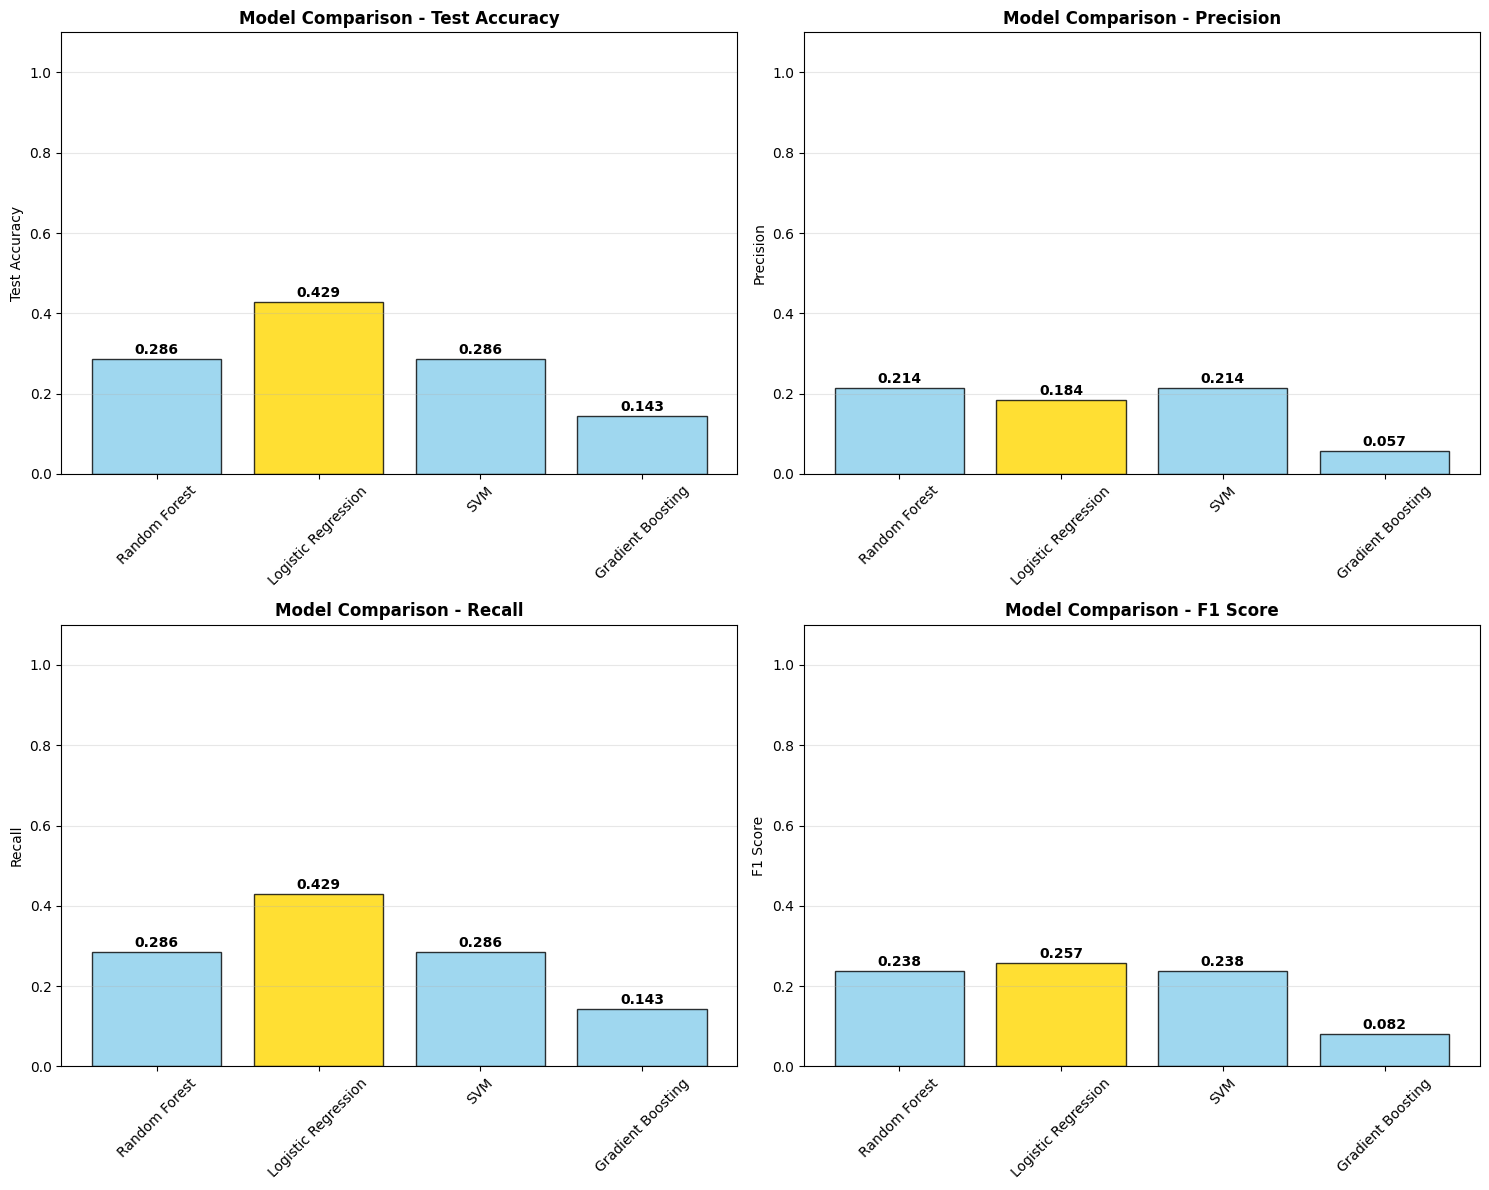

✅ Generated model comparison visualization


In [14]:
# Create model comparison visualization
print("📈 Creating model performance comparison plot...")

# Prepare data for visualization
metrics_map = {
    'Test Accuracy': 'test_accuracy',
    'Precision': 'precision', 
    'Recall': 'recall',
    'F1 Score': 'f1_score'
}

models = list(training_results.keys())

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, (metric_name, metric_key) in enumerate(metrics_map.items()):
    ax = axes[i]
    
    # Get metric values
    values = [training_results[model][metric_key] for model in models]
    colors = ['gold' if model == best_model_name else 'skyblue' for model in models]
    
    # Create bar plot
    bars = ax.bar(models, values, color=colors, alpha=0.8, edgecolor='black')
    ax.set_title(f'Model Comparison - {metric_name}', fontweight='bold')
    ax.set_ylabel(metric_name)
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Set y-axis limits for better visualization
    ax.set_ylim(0, 1.1)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✅ Generated model comparison visualization")

🔍 Creating feature importance plots...


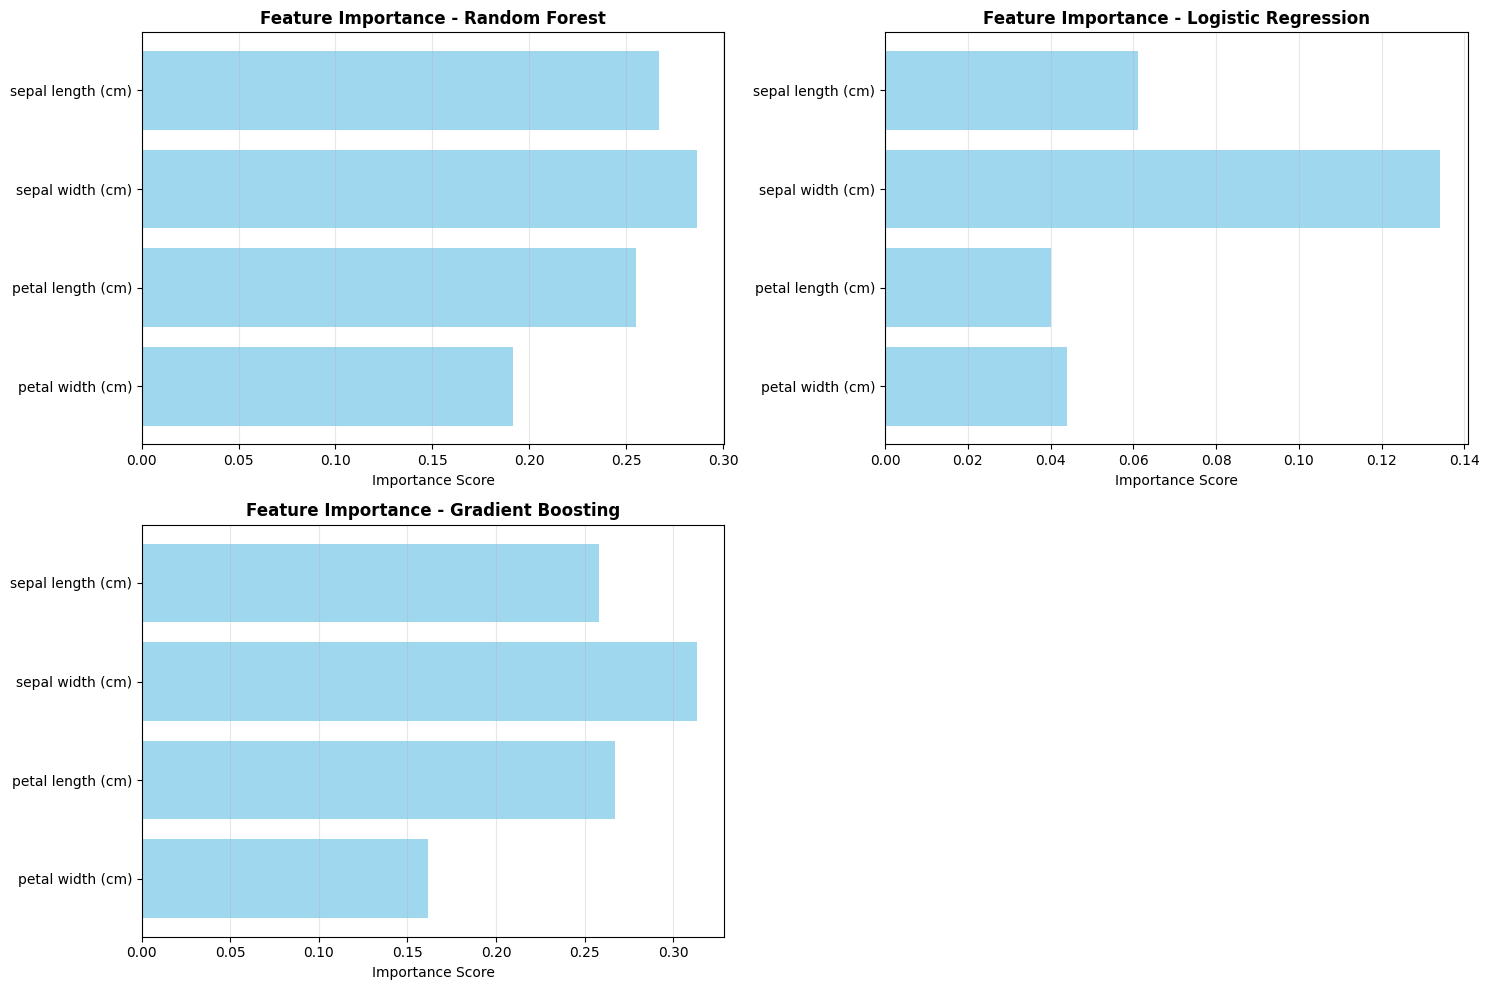

📊 Feature importance plots created for 3 models
✅ Feature importance analysis completed


In [15]:
# Feature importance plots for models that support it
print("🔍 Creating feature importance plots...")

# Only include models that have feature importance
models_with_importance = {}
for name, result in training_results.items():
    if 'feature_importance' in result and result['feature_importance'] is not None:
        models_with_importance[name] = result

if models_with_importance:
    n_models = len(models_with_importance)
    n_cols = 2
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    if n_rows == 1:
        axes = [axes] if n_models == 1 else axes
    else:
        axes = axes.ravel()
    
    for idx, (model_name, result) in enumerate(models_with_importance.items()):
        ax = axes[idx] if n_models > 1 else axes
        
        # Get feature importance from dictionary
        feature_importance = result['feature_importance']
        features = list(feature_importance.keys())
        importance_values = list(feature_importance.values())
        
        # Create horizontal bar plot
        y_pos = np.arange(len(features))
        ax.barh(y_pos, importance_values, alpha=0.8, color='skyblue')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(features)
        ax.invert_yaxis()
        ax.set_xlabel('Importance Score')
        ax.set_title(f'Feature Importance - {model_name}', fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')
    
    # Remove empty subplots
    for idx in range(len(models_with_importance), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()
    
    print(f"📊 Feature importance plots created for {len(models_with_importance)} models")
else:
    print("ℹ️  No models with feature importance available")

print("✅ Feature importance analysis completed")

## 6. Model Selection and Analysis

Select the best model and perform detailed analysis.

In [16]:
# Detailed analysis of the best model
print("Best Model Analysis:")
print("=" * 50)

print(f"\nSelected Model: {best_model_name}")
print(f"Test Accuracy: {best_result['test_accuracy']:.4f}")
print(f"Training Accuracy: {best_result['train_accuracy']:.4f}")
print(f"Cross-Validation Score: {best_result['cv_mean']:.4f} ± {best_result['cv_std']:.4f}")
print(f"Training Time: {best_result['training_time']:.2f} seconds")

# Performance metrics
print(f"\nDetailed Performance Metrics:")
print(f"  • Precision: {best_result['precision']:.4f}")
print(f"  • Recall: {best_result['recall']:.4f}")
print(f"  • F1-Score: {best_result['f1_score']:.4f}")

# Best hyperparameters
print(f"\nOptimized Hyperparameters:")
for param, value in best_result['best_params'].items():
    print(f"  {param}: {value}")

# Performance insights
print(f"\nPerformance Insights:")
accuracy_gap = abs(best_result['train_accuracy'] - best_result['test_accuracy'])
print(f"  • Training vs Test Accuracy Gap: {accuracy_gap:.4f}")
if accuracy_gap > 0.05:
    print(f"    WARNING: Large gap may indicate overfitting")
else:
    print(f"    GOOD: Good generalization capability")

print(f"  • CV Standard Deviation: {best_result['cv_std']:.4f}")
if best_result['cv_std'] > 0.05:
    print(f"    WARNING: High variance across CV folds")
else:
    print(f"    GOOD: Stable performance across folds")

print(f"\nModel Ranking by Test Accuracy:")
# Sort all models by test accuracy
sorted_models = sorted(training_results.items(), 
                      key=lambda x: x[1]['test_accuracy'], 
                      reverse=True)
for i, (name, result) in enumerate(sorted_models, 1):
    print(f"  {i}. {name}: {result['test_accuracy']:.4f}")

print("\nBest model analysis completed")

Best Model Analysis:

Selected Model: Logistic Regression
Test Accuracy: 0.4286
Training Accuracy: 0.4536
Cross-Validation Score: 0.3611 ± 0.0584
Training Time: 0.06 seconds

Detailed Performance Metrics:
  • Precision: 0.1837
  • Recall: 0.4286
  • F1-Score: 0.2571

Optimized Hyperparameters:
  C: 0.1
  solver: lbfgs

Performance Insights:
  • Training vs Test Accuracy Gap: 0.0250
    GOOD: Good generalization capability
  • CV Standard Deviation: 0.0584

Model Ranking by Test Accuracy:
  1. Logistic Regression: 0.4286
  2. Random Forest: 0.2857
  3. SVM: 0.2857
  4. Gradient Boosting: 0.1429

Best model analysis completed


In [17]:
# Show some prediction examples
print("Prediction Examples (Best Model):")
print("=" * 50)

# Make predictions with the best model
best_model_predictions = best_model.predict(X_test)
best_model_probabilities = None

if hasattr(best_model, 'predict_proba'):
    best_model_probabilities = best_model.predict_proba(X_test)

# Show first 10 predictions
print("\nFirst 10 Test Predictions:")
print(f"{'Index':<6} {'Actual':<12} {'Predicted':<12} {'Correct':<8}")
print("-" * 45)

for i in range(min(10, len(X_test))):
    actual = y_test.iloc[i]
    predicted = best_model_predictions[i]
    is_correct = "YES" if actual == predicted else "NO"
    
    print(f"{i:<6} {actual:<12} {predicted:<12} {is_correct:<8}")

# Accuracy breakdown by class
print("\nAccuracy by Class:")
from sklearn.metrics import classification_report
class_report = classification_report(y_test, best_model_predictions, output_dict=True)

for class_name in sorted(y_test.unique()):
    if str(class_name) in class_report:
        precision = class_report[str(class_name)]['precision']
        recall = class_report[str(class_name)]['recall']
        f1 = class_report[str(class_name)]['f1-score']
        support = class_report[str(class_name)]['support']
        
        print(f"  Class {class_name}:")
        print(f"    Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f} ({int(support)} samples)")

print("\nPrediction examples completed")

Prediction Examples (Best Model):

First 10 Test Predictions:
Index  Actual       Predicted    Correct 
---------------------------------------------
0      1.0          0.0          NO      
1      0.0          0.0          YES     
2      0.0          0.0          YES     
3      0.0          0.0          YES     
4      2.0          0.0          NO      
5      1.0          0.0          NO      
6      2.0          0.0          NO      

Accuracy by Class:
  Class 0.0:
    Precision: 0.429, Recall: 1.000, F1: 0.600 (3 samples)
  Class 1.0:
    Precision: 0.000, Recall: 0.000, F1: 0.000 (2 samples)
  Class 2.0:
    Precision: 0.000, Recall: 0.000, F1: 0.000 (2 samples)

Prediction examples completed


## 7. Model Persistence and Summary

Save the best model, create metadata, and provide final summary.

In [18]:
# Save trained models to Google Cloud Storage
print("💾 Saving trained models to Google Cloud Storage...")

# Import json at the top level 
import json

def save_models_to_gcs(all_models_dict, best_model, training_results, timestamp_str):
    """Save all trained models and results to GCS with local backup"""
    
    artifacts = {
        'gcs_paths': {},
        'local_backup_paths': {}
    }
    
    try:
        if storage_client is not None:
            bucket = storage_client.bucket(MODELS_BUCKET)
            print(f"☁️ Uploading models to GCS bucket: {MODELS_BUCKET}")
            
            import tempfile
            import os
            
            # 1. Save all models dictionary
            with tempfile.NamedTemporaryFile(mode='wb', suffix='.pkl', delete=False) as tmp:
                pickle.dump(all_models_dict, tmp.file)
                tmp.file.flush()
                all_models_blob = bucket.blob(f"trained-models/all_models_{timestamp_str}.pkl")
                all_models_blob.upload_from_filename(tmp.name)
                artifacts['gcs_paths']['all_models'] = f"gs://{MODELS_BUCKET}/trained-models/all_models_{timestamp_str}.pkl"
                os.unlink(tmp.name)
            
            # 2. Save best model separately
            with tempfile.NamedTemporaryFile(mode='wb', suffix='.pkl', delete=False) as tmp:
                pickle.dump(best_model, tmp.file)
                tmp.file.flush()
                best_model_blob = bucket.blob(f"trained-models/best_model_{timestamp_str}.pkl")
                best_model_blob.upload_from_filename(tmp.name)
                artifacts['gcs_paths']['best_model'] = f"gs://{MODELS_BUCKET}/trained-models/best_model_{timestamp_str}.pkl"
                os.unlink(tmp.name)
            
            # 3. Save training results and metadata
            with tempfile.NamedTemporaryFile(mode='wb', suffix='.pkl', delete=False) as tmp:
                pickle.dump(training_results, tmp.file)
                tmp.file.flush()
                results_blob = bucket.blob(f"training-results/training_results_{timestamp_str}.pkl")
                results_blob.upload_from_filename(tmp.name)
                artifacts['gcs_paths']['training_results'] = f"gs://{MODELS_BUCKET}/training-results/training_results_{timestamp_str}.pkl"
                os.unlink(tmp.name)
            
            # 4. Save model metadata as JSON for easy inspection
            model_metadata = {
                'timestamp': timestamp_str,
                'best_model_name': best_model_name,
                'best_model_accuracy': float(best_result['test_accuracy']),
                'training_time_seconds': float(best_result['training_time']),
                'models_trained': list(training_results.keys()),
                'feature_columns': feature_columns,
                'target_column': target_column,
                'training_data_shape': list(train_data.shape),
                'test_data_shape': list(test_data.shape),
                'random_state': RANDOM_STATE,
                'data_source': data_source,
                'gcs_paths': artifacts['gcs_paths']
            }
            
            with tempfile.NamedTemporaryFile(mode='w', suffix='.json', delete=False) as tmp:
                json.dump(model_metadata, tmp.file, indent=2)
                tmp.file.flush()
                metadata_blob = bucket.blob(f"model-metadata/model_metadata_{timestamp_str}.json")
                metadata_blob.upload_from_filename(tmp.name)
                artifacts['gcs_paths']['model_metadata'] = f"gs://{MODELS_BUCKET}/model-metadata/model_metadata_{timestamp_str}.json"
                os.unlink(tmp.name)
            
            print("✅ Models uploaded to GCS successfully")
        else:
            print("⚠️ GCS client not available, saving locally only")
        
    except Exception as e:
        print(f"⚠️ GCS upload error: {e}")
        print("   Models will be saved locally only")
    
    # Always create local backup
    print("💾 Creating local backup...")
    
    # Save to local paths for backup
    all_models_path = MODELS_DIR / f"all_models_{timestamp_str}.pkl"
    best_model_path = MODELS_DIR / f"best_model_{timestamp_str}.pkl" 
    training_results_path = MODELS_DIR / f"training_results_{timestamp_str}.pkl"
    metadata_path = MODELS_DIR / f"model_metadata_{timestamp_str}.json"
    
    # Create model metadata for local save
    model_metadata = {
        'timestamp': timestamp_str,
        'best_model_name': best_model_name,
        'best_model_accuracy': float(best_result['test_accuracy']),
        'training_time_seconds': float(best_result['training_time']),
        'models_trained': list(training_results.keys()),
        'feature_columns': feature_columns,
        'target_column': target_column,
        'training_data_shape': list(train_data.shape),
        'test_data_shape': list(test_data.shape),
        'random_state': RANDOM_STATE,
        'data_source': data_source
    }
    
    # Save local files
    with open(all_models_path, 'wb') as f:
        pickle.dump(all_models_dict, f)
    artifacts['local_backup_paths']['all_models'] = str(all_models_path)
    
    with open(best_model_path, 'wb') as f:
        pickle.dump(best_model, f)
    artifacts['local_backup_paths']['best_model'] = str(best_model_path)
    
    with open(training_results_path, 'wb') as f:
        pickle.dump(training_results, f)
    artifacts['local_backup_paths']['training_results'] = str(training_results_path)
    
    with open(metadata_path, 'w') as f:
        json.dump(model_metadata, f, indent=2)
    artifacts['local_backup_paths']['model_metadata'] = str(metadata_path)
    
    print("✅ Local backup created successfully")
    
    return artifacts

# Generate timestamp for this training session
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Create all_models_dict with all trained models
all_models_dict = {name: result['model'] for name, result in training_results.items()}

# Save all trained models and results
print(f"\n💾 Saving models and results...")
print(f"   🏆 Best model: {best_model_name} ({best_result['test_accuracy']:.4f} accuracy)")
print(f"   📊 Total models trained: {len(training_results)}")

model_artifacts = save_models_to_gcs(
    all_models_dict=all_models_dict,
    best_model=best_model, 
    training_results=training_results,
    timestamp_str=timestamp
)

print(f"\n🎯 Model Training Complete!")
print(f"📊 Artifacts created:")
for storage_type, paths in model_artifacts.items():
    if paths:
        print(f"   {storage_type.upper()}:")
        for name, path in paths.items():
            print(f"     {name}: {path}")

print(f"\n✅ Models are saved and ready for deployment!")

💾 Saving trained models to Google Cloud Storage...

💾 Saving models and results...
   🏆 Best model: Logistic Regression (0.4286 accuracy)
   📊 Total models trained: 4
☁️ Uploading models to GCS bucket: mlops-295610-mlops-models
✅ Models uploaded to GCS successfully
💾 Creating local backup...
✅ Local backup created successfully

🎯 Model Training Complete!
📊 Artifacts created:
   GCS_PATHS:
     all_models: gs://mlops-295610-mlops-models/trained-models/all_models_20251124_194128.pkl
     best_model: gs://mlops-295610-mlops-models/trained-models/best_model_20251124_194128.pkl
     training_results: gs://mlops-295610-mlops-models/training-results/training_results_20251124_194128.pkl
     model_metadata: gs://mlops-295610-mlops-models/model-metadata/model_metadata_20251124_194128.json
   LOCAL_BACKUP_PATHS:
     all_models: ../models/all_models_20251124_194128.pkl
     best_model: ../models/best_model_20251124_194128.pkl
     training_results: ../models/training_results_20251124_194128.pkl


In [19]:
# Clean up and final notes
plt.close('all')  # Close all matplotlib figures

print("Resources cleaned up")
print("Model training notebook completed successfully!")
print("\nRelated Notebooks:")
print("  01_getting_started.ipynb - Environment setup")
print("  02_data_processing_pipeline.ipynb - Data preparation")
print("  03_model_training.ipynb - Current notebook")
print("  04_vertex_ai_training.ipynb - Cloud training (Next)")
print("  05_model_deployment.ipynb - Model deployment (Next)")

print("\nFinal Summary:")
print(f"  Best Model: {best_model_name}")
print(f"  Test Accuracy: {best_result['test_accuracy']:.4f}")
print(f"  Training Time: {best_result['training_time']:.2f} seconds")
print(f"  Models Saved: {MODELS_DIR}")

print("\nModel training notebook completed successfully!")

Resources cleaned up
Model training notebook completed successfully!

Related Notebooks:
  01_getting_started.ipynb - Environment setup
  02_data_processing_pipeline.ipynb - Data preparation
  03_model_training.ipynb - Current notebook
  04_vertex_ai_training.ipynb - Cloud training (Next)
  05_model_deployment.ipynb - Model deployment (Next)

Final Summary:
  Best Model: Logistic Regression
  Test Accuracy: 0.4286
  Training Time: 0.06 seconds
  Models Saved: ../models

Model training notebook completed successfully!
